## Install PySpark Dependencies

In [ ]:
# Install Spark dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!rm spark-3.2.3-bin-hadoop3.2.tgz
!wget --no-cookies --no-check-certificate https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
!tar zxvf spark-3.2.3-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark==3.2.3

In [2]:
!ls -al | grep spark

drwxr-xr-x 13  501 1000      4096 Nov 14 17:54 spark-3.2.3-bin-hadoop3.2
-rw-r--r--  1 root root 301136158 Nov 14 18:47 spark-3.2.3-bin-hadoop3.2.tgz


## Load Data

In [ ]:
!wget https://raw.githubusercontent.com/zaratsian/Datasets/master/banking_attrition.csv

## Import Python / Spark Libraries

In [9]:
import os
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

import datetime, time
import re, random, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import T, StructType, StructField, ArrayType, IntegerType, StringType, FloatType, LongType, DateType, DoubleType
from pyspark.sql.functions import struct, array, lit, monotonically_increasing_id, col, expr, when, concat, udf, split, size, lag, count, isnull, rand, countDistinct, F
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, IndexToString, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

## Create Spark Session

In [78]:
spark = SparkSession.builder.appName("Spark ML Assignment").master("local[*]").getOrCreate()

## Load CSV Data into Spark Dataframe

In [79]:
# load the data to Spark dataframe
df= spark.read.load("banking_attrition.csv", format="csv", header=True, inferSchema=True)

In [80]:
from pyspark.sql import DataFrame
if isinstance(df, DataFrame):
    print("The variable 'df' is a Spark DataFrame.")
else:
    print("The variable 'df' is not a Spark DataFrame.")

The variable 'df' is a Spark DataFrame.


In [81]:
# display the dataset
df.show(5,False)

+-------+---+---------+--------------+--------------+-----------+-------+-------+----+------+-------------+----------+-------+-----------------+---------+
|uid    |age|age_group|profession    |marital_status|education  |default|housing|loan|gender|balance      |membership|charges|customer_contacts|attrition|
+-------+---+---------+--------------+--------------+-----------+-------+-------+----+------+-------------+----------+-------+-----------------+---------+
|1000001|69 |60s      |retired       |married       |high school|no     |no     |no  |female|$50k - $100k |gold      |74     |5                |0        |
|1000002|46 |40s      |management    |married       |high school|yes    |no     |no  |male  |$10k - $50k  |silver    |149    |1                |0        |
|1000003|45 |40s      |management    |married       |high school|no     |no     |no  |female|$100k - $250k|platinum  |58     |5                |1        |
|1000004|54 |50s      |administration|divorced      |graduate   |no   

In [82]:
# check fundamentals
df.printSchema()

root
 |-- uid: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- balance: string (nullable = true)
 |-- membership: string (nullable = true)
 |-- charges: integer (nullable = true)
 |-- customer_contacts: integer (nullable = true)
 |-- attrition: integer (nullable = true)



##Data Exploration

In [83]:
# understand unique counts in dataframe
df.select(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+-----+---+---------+----------+--------------+---------+-------+-------+----+------+-------+----------+-------+-----------------+---------+
|  uid|age|age_group|profession|marital_status|education|default|housing|loan|gender|balance|membership|charges|customer_contacts|attrition|
+-----+---+---------+----------+--------------+---------+-------+-------+----+------+-------+----------+-------+-----------------+---------+
|45211| 76|        9|        12|             3|        4|      2|      2|   2|     2|      5|         3|    348|               10|        2|
+-----+---+---------+----------+--------------+---------+-------+-------+----+------+-------+----------+-------+-----------------+---------+



In [84]:
# Category Variables
categorical_columns = [c[0] for c in df.dtypes if c[1] in ['string']]
[df.select(df[c]).groupBy(df[c]).count().show(5,False) for c in categorical_columns]

+---------+-----+
|age_group|count|
+---------+-----+
|40s      |9748 |
|80s      |107  |
|70s      |362  |
|90s      |6    |
|20s      |8044 |
+---------+-----+
only showing top 5 rows

+--------------+-----+
|profession    |count|
+--------------+-----+
|management    |8406 |
|retired       |2061 |
|unknown       |275  |
|administration|6640 |
|executive     |1165 |
+--------------+-----+
only showing top 5 rows

+--------------+-----+
|marital_status|count|
+--------------+-----+
|divorced      |11213|
|married       |20043|
|single        |13955|
+--------------+-----+

+-----------+-----+
|education  |count|
+-----------+-----+
|graduate   |26508|
|college    |4931 |
|unknown    |1342 |
|high school|12430|
+-----------+-----+

+-------+-----+
|default|count|
+-------+-----+
|no     |44396|
|yes    |815  |
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|no     |20081|
|yes    |25130|
+-------+-----+

+----+-----+
|loan|count|
+----+-----+
|no  |37967|
|yes |7244 |

[None, None, None, None, None, None, None, None, None, None]

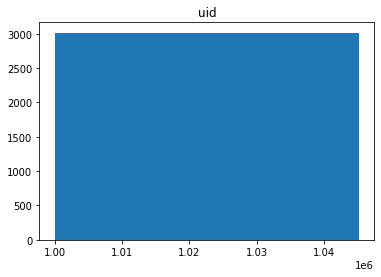

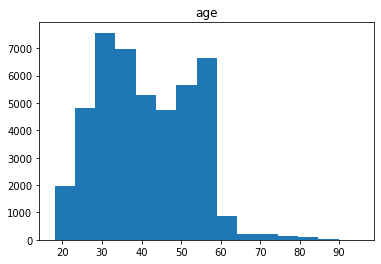

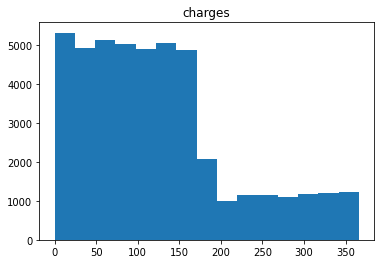

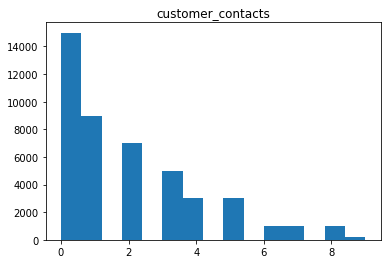

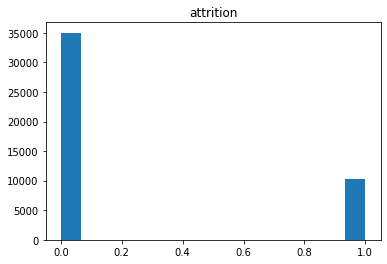

In [85]:
# Numerical Variables
num_cols = [c for c, t in df.dtypes if t != "string"]

# plot histograms for all numerical columns
for col_name in num_cols:
    data = df.select(col(col_name)).rdd.flatMap(lambda x: x).collect()
    plt.hist(data, bins=15)
    plt.title(col_name)
    plt.show()

In [86]:
# Classes Ratio on target variable
df.groupBy('attrition').count().show()
print("\n")
df.groupBy('attrition').count().withColumn('percentage', F.col('count')/Fsum('count').over(Window.partitionBy())).show()

+---------+-----+
|attrition|count|
+---------+-----+
|        1|10200|
|        0|35011|
+---------+-----+



+---------+-----+-------------------+
|attrition|count|         percentage|
+---------+-----+-------------------+
|        1|10200|0.22560881201477517|
|        0|35011| 0.7743911879852249|
+---------+-----+-------------------+



In [87]:
# Caregorical with Target variable
df.groupby(['age_group','attrition']).count().sort(['age_group','attrition']).show(),
df.groupby(['profession','attrition']).count().sort(['profession','attrition']).show(),
df.groupby(['marital_status','attrition']).count().sort(['marital_status','attrition']).show(),
df.groupby(['education','attrition']).count().sort(['education','attrition']).show(),
df.groupby(['default','attrition']).count().sort(['default','attrition']).show(),
df.groupby(['housing','attrition']).count().sort(['housing','attrition']).show(),
df.groupby(['loan','attrition']).count().sort(['loan','attrition']).show(),
df.groupby(['gender','attrition']).count().sort(['gender','attrition']).show(),
df.groupby(['balance','attrition']).count().sort(['balance','attrition']).show(),
df.groupby(['membership','attrition']).count().sort(['membership','attrition']).show()

+---------+---------+-----+
|age_group|attrition|count|
+---------+---------+-----+
|      20s|        0| 3887|
|      20s|        1| 4157|
|      30s|        0|13539|
|      30s|        1|  861|
|      40s|        0| 9156|
|      40s|        1|  592|
|      50s|        0| 6948|
|      50s|        1| 4469|
|      60s|        0| 1000|
|      60s|        1|   91|
|      70s|        0|  341|
|      70s|        1|   21|
|      80s|        0|  103|
|      80s|        1|    4|
|      90s|        0|    5|
|      90s|        1|    1|
|      U20|        0|   32|
|      U20|        1|    4|
+---------+---------+-----+

+--------------+---------+-----+
|    profession|attrition|count|
+--------------+---------+-----+
|administration|        0| 3833|
|administration|        1| 2807|
|    consulting|        0| 3062|
|    consulting|        1|  530|
|  entrepreneur|        0| 1173|
|  entrepreneur|        1|  156|
|     executive|        0| 1055|
|     executive|        1|  110|
|    management|    

In [88]:
# Define the columns to encode
columns_to_encode = ["age_group", "profession", "marital_status", "education", "default", "housing", "loan", "gender", "balance", "membership"]

# Apply string indexing to the columns to encode
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_indexed") for column in columns_to_encode]
indexed = indexers[0].fit(df).transform(df)
for indexer in indexers[1:]:
    indexed = indexer.fit(indexed).transform(indexed)

# Apply one-hot encoding to the indexed columns
encoders = [OneHotEncoder(inputCol=f"{column}_indexed", outputCol=f"{column}_onehot") for column in columns_to_encode]
encoded = encoders[0].fit(indexed).transform(indexed)
for encoder in encoders[1:]:
    encoded = encoder.fit(encoded).transform(encoded)

In [89]:
# show the result
encoded.show(5)

+-------+---+---------+--------------+--------------+-----------+-------+-------+----+------+-------------+----------+-------+-----------------+---------+-----------------+------------------+----------------------+-----------------+---------------+---------------+------------+--------------+---------------+------------------+----------------+-----------------+---------------------+----------------+--------------+--------------+-------------+-------------+--------------+-----------------+
|    uid|age|age_group|    profession|marital_status|  education|default|housing|loan|gender|      balance|membership|charges|customer_contacts|attrition|age_group_indexed|profession_indexed|marital_status_indexed|education_indexed|default_indexed|housing_indexed|loan_indexed|gender_indexed|balance_indexed|membership_indexed|age_group_onehot|profession_onehot|marital_status_onehot|education_onehot|default_onehot|housing_onehot|  loan_onehot|gender_onehot|balance_onehot|membership_onehot|
+-------+---+-

<Axes: >

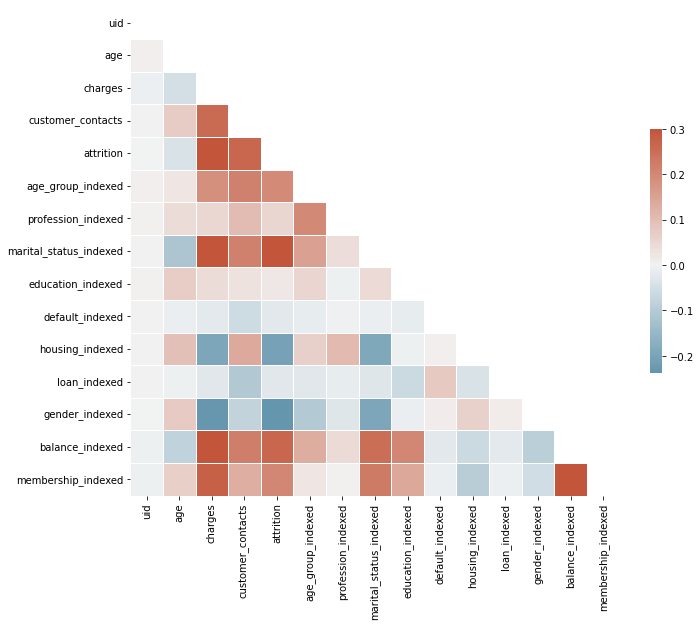

In [90]:
# some insights into the relationship between features
# observe the correlation

# Generate a mask for the upper triangle
corr = encoded.toPandas().corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Split the Spark Dataframe into Train and Test

In [91]:
from pyspark.ml.tuning import TrainValidationSplit

In [92]:
train, test = encoded.randomSplit([0.7, 0.3], seed=42)

In [93]:
print("Train:\n")
(train.groupBy("attrition").count().withColumnRenamed("count", "count_train").withColumn("percentage_train", F.col("count_train")/train.count())).show()
print("\n")
print("Test:\n")
(test.groupBy("attrition").count().withColumnRenamed("count", "count_test").withColumn("percentage_test", F.col("count_test")/test.count())).show()

Train:

+---------+-----------+------------------+
|attrition|count_train|  percentage_train|
+---------+-----------+------------------+
|        1|       7212|0.2274146249172264|
|        0|      24501|0.7725853750827736|
+---------+-----------+------------------+



Test:

+---------+----------+-------------------+
|attrition|count_test|    percentage_test|
+---------+----------+-------------------+
|        1|      2988|0.22136612831530597|
|        0|     10510|  0.778633871684694|
+---------+----------+-------------------+



## Feature Engineering

In [94]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

In [95]:
target   = 'attrition'
features = [f"{column}_onehot" for column in columns_to_encode]

# encode the Label column (feature indexer)
si = StringIndexer(inputCol='attrition', outputCol='label').fit(train)

# pipeline requires i/p variables passed as a vector
va  = VectorAssembler(inputCols=features, outputCol="features")

In [96]:
# run the algorithm
rf = RandomForestRegressor(featuresCol="features", labelCol='label', predictionCol="prediction", 
                            maxDepth=5, maxBins=200, seed=42)

# convert indexed labels to original labels
lc = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si.labels)

#### Model Building Pipeline

In [97]:
# build ML pipeline
pipeline_run  = Pipeline(stages=[si, va, rf, lc])

# pipeline model
model_run = pipeline_run.fit(train)

## Make predictions

In [98]:
pred = model_run.transform(test)

In [99]:
pred.show(3)

+-------+---+---------+------------+--------------+-----------+-------+-------+----+------+-------------+----------+-------+-----------------+---------+-----------------+------------------+----------------------+-----------------+---------------+---------------+------------+--------------+---------------+------------------+----------------+-----------------+---------------------+----------------+--------------+--------------+-------------+-------------+--------------+-----------------+-----+--------------------+-------------------+--------------+
|    uid|age|age_group|  profession|marital_status|  education|default|housing|loan|gender|      balance|membership|charges|customer_contacts|attrition|age_group_indexed|profession_indexed|marital_status_indexed|education_indexed|default_indexed|housing_indexed|loan_indexed|gender_indexed|balance_indexed|membership_indexed|age_group_onehot|profession_onehot|marital_status_onehot|education_onehot|default_onehot|housing_onehot|  loan_onehot|gend

In [100]:
# generate results for the classifier
preds=pred.select(pred["attrition"],pred["predictedLabel"],pred["prediction"])

In [101]:
preds.show(3)

+---------+--------------+-------------------+
|attrition|predictedLabel|         prediction|
+---------+--------------+-------------------+
|        1|             0|0.09433553995913202|
|        0|             0|0.11072223159116508|
|        0|             0|0.09225095154568252|
+---------+--------------+-------------------+
only showing top 3 rows



In [102]:
# evaluate the result
preds_final=preds.withColumn("attrition",preds.attrition.cast('double'))

In [103]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="attrition",labelCol="prediction")
auc=evaluator.evaluate(preds_final)
print("AUC:",auc)

AUC: 0.9566048349318859
